## Outline

* load marker swarms, and make a quasi-analytic correction for the boundary layer growth
* evaluate pressure and velocity and dip, try to determine relationships

In [1]:
velScale = 3.4482758620689656e-13*(3600*24*365)*100.  #cm/y
timeScale = 8.41e+18/(1e6*3600*24*365)    
tempScale = 1400.0
stressScale = 11.890606


In [2]:
#If run through Docker we'll point at the local 'unsupported dir.'
#On hpc, the path should also include a directory holding the unsupported_dan.
import sys

#this does't actually need to be protected. More a reminder it's an interim measure
try:
    sys.path.append('../../UWsubduction/')
    #use this block to point to a local version of UWsubduction

except:
    pass

In [3]:
%pylab inline
import numpy as np

import seaborn as sns
import glob2
import pandas as pd
import h5py
from scipy.ndimage.filters import gaussian_filter
import natsort
from scipy.interpolate import CubicSpline
import numpy as np
from scipy.ndimage.filters import gaussian_filter
import UWsubduction as usub
from scipy.spatial import cKDTree as kdTree
from scipy import integrate


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
import sys
sys.path.append('../../unsupported')

import underworld as uw
import math
from underworld import function as fn



In [5]:
Mod = 'B'
Num = '16'
hf = h5py.File('/workspace2/flat_slab/{}/{}/mesh.h5'.format(Mod,Num), 'r')
meshData = np.array(hf.get("vertices"))

In [6]:
#meshData.shape
#(222529,2) into shape (148417,2)

In [7]:
#mesh info.
elementType = 'Q1/dQ0'
xres, yres = 192*6, 192
#xres, yres = 384*4, 384
leftLim, bottom = meshData[:,0].min(), meshData[:,1].min() 
rightLim = meshData[:,0].max()



In [8]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = (elementType),
                                 elementRes  = (xres, yres), 
                                 minCoord    = (leftLim, bottom), 
                                 maxCoord    = (rightLim, 1.)) 

In [9]:
with mesh.deform_mesh():
    mesh.data[:] = meshData

In [10]:
vField   = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
pField   = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
tField   = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )

marker = usub.interface2D(mesh, vField,[], [], 1e-2,  1, insidePt=(-0.5,0.5))


## get Data

In [11]:
def get_dataframe(M, N):
    file_ = '../models/results/{}/{}/values/tect_model_data.npz'.format(M, N)
    #file_ = '../models/results/A/{}/values/tect_model_data.npz'.format(num)
    out = np.load(file_)
    d = dict(out)
    df = pd.DataFrame.from_dict(d)
    return df 

def listify_data(unique_string, path):
    glob_str = path + '*' + unique_string + '*'
    files = natsort.natsort(glob2.glob(glob_str))
    #print(glob_str)
    #return files
    
    dataList = []
    for f in files:
        with h5py.File(f,'r') as hf:
            data = hf.get('data')
            dataList.append(np.array(data))
    return dataList

def prune_recursive(data, n, tol = 0.1, safe = 5):
    """
    We want to avoid points where the slab is inverted.
    We recursively eliminate points from the deepest

    """
    
    
    #assume data is not depth odrered
    
    ysorted = data[np.argsort(data[:,1])]
    xsortedData = ysorted[np.argsort(ysorted[:,0])]
    
    ds = abs(np.mean(np.diff(xsortedData[:,0][10:110])))
    
    mask = 0

    while np.abs(np.max(np.diff(xsortedData[:,1]))) > ds*tol:
        mask += n
        ysorted = data[np.argsort(data[:,1])][mask:]
        xsortedData = ysorted[np.argsort(ysorted[:,0])]
    
    ysorted = data[np.argsort(data[:,1])][mask + safe:]
    xsortedData = ysorted[np.argsort(ysorted[:,0])]
    return xsortedData 

## MDD

In [12]:
def mddFn(depths, yvels, gf= 2, maxReduce = 4.):
    for i in range(len(depths)):
        indexes  = argsort(depths[i]) 
        mask = depths[i][indexes] > 50
        vel = gaussian_filter(-1.*yvels[i][indexes][mask], gf)
        ref = (vel).max()/maxReduce
        index = np.argmin(np.abs(vel  - ref))
        mddF = depths[i][indexes][mask][index]
        yield mddF/2900.

In [13]:
mantlePointsList = listify_data('mantleEval', '../models/results/{}/{}/**/'.format("B", '16'))
mantleVelYList= listify_data('mantleVelY', '../models/results/{}/{}/**/'.format("B", '16'))
mantleDimDepths = [(1. - m[:,1])*2900.0  for m in mantlePointsList] 
MDDB16 = np.array(list( mddFn(mantleDimDepths, mantleVelYList)))

In [14]:
#ls ../models/results/B/16/files/

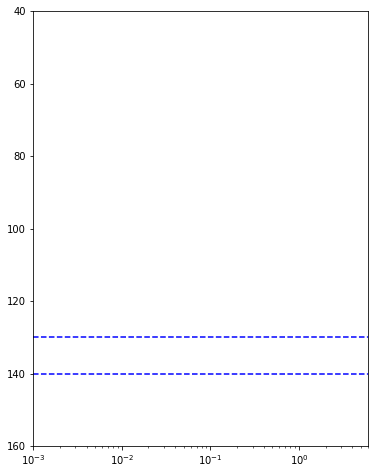

In [15]:


cp = sns.color_palette("coolwarm", len(range(20, len(mantleVelYList), 5)))

fig, ax = plt.subplots(figsize=(6, 8))

ci = 0
for i in range(20, len(mantleVelYList), 5):
    indexes = np.argsort(mantlePointsList[i][:,0])
    ax.plot( gaussian_filter(-1*velScale*mantleVelYList[i][indexes ], 2) , 
            (1. - mantlePointsList[i][indexes ,1])*2900.0, c = cp[ci], lw= 0.8)
    
    ci += 1

ax.vlines(0, 0, 200, linestyles='--')

#ax.hlines(90, -250, 200, colors='r', linestyles='--')
ax.hlines(140, 0.001, 6, colors='b', linestyles='--')
ax.hlines(130, 0.001, 6, colors='b', linestyles='--')


ax.set_xlim(0.001, 6)
ax.set_ylim(160, 40)

ax.set_xscale('log')



## Manual test


THis generates the figures for the paper. 

The Deep decoupling fugure was generated using model B 25, step index 81

The Shallow decoupling figure was genewrated ising C 32. step index 41. 

Both shold return the state at the first time step after 20 Myr

In [16]:
#adiabatTempGrad = 0.814824856
adiabatTempGrad = 0.

In [17]:
ls ../models/results/B/16/values/

tect_model_data.npz


In [72]:
#Mod = 'C'
#Num = '32'
#index = 41

Mod = 'B'
Num = '16'
#index = 68
index = 76



testDf = get_dataframe(Mod, Num)
print(testDf.timeAtSave.iloc[index]*timeScale)
trench = testDf['(1, 2)'][index]*2900. - 40
trenchMod = trench/2900.

hf = h5py.File('/workspace2/flat_slab/{}/{}/mesh.h5'.format(Mod,Num), 'r')
meshData = np.array(hf.get("vertices"))

#Temp data
tempFiles = natsort.natsort(glob2.glob('/workspace2/flat_slab/{}/{}/**temp**h5'.format(Mod,Num)))
hf = h5py.File(tempFiles[index ], 'r')
temp = np.array(hf.get("data"))[:,0]
temp0 = temp.copy()*tempScale
temp += adiabatTempGrad*( 1. - meshData[:,1])
temp*=tempScale

#Pressure
pressFiles = natsort.natsort(glob2.glob('/workspace2/flat_slab/{}/{}/**press**h5'.format(Mod,Num)))
hf = h5py.File(pressFiles[index ], 'r')
press = np.array(hf.get("data"))[:,0]
press*=stressScale*1e-6


#Stress Inv
stressFiles = natsort.natsort(glob2.glob('/workspace2/flat_slab/{}/{}/**sigII**h5'.format(Mod,Num)))
hf = h5py.File(stressFiles[index ], 'r')
stress = np.array(hf.get("data"))[:,0]
stress*=stressScale*1e-6

pointsList = listify_data('interface', '../models/results/{}/{}/**/'.format(Mod,Num))


#Get the mantle tracer line + values
#mantlePointsList = listify_data('mantleEval', '../models/results/{}/{}/**/'.format(Mod,Num))
#mantleVelYList= listify_data('mantleVelY', '../models/results/{}/{}/**/'.format(Mod,Num))
#mantleDimDepths = [(1. - m[:,1])*2900.0  for m in mantlePointsList] 


#Wrangle the interface data

#velFiles = natsort.natsort(glob2.glob('/workspace2/slab_stress/{}/{}/**vel**h5'.format(Mod,Num)))
#hf = h5py.File(velFiles[index ], 'r')
#vel = np.array(hf.get("data"))[:,:]
#vel*=velScale
#opRate = 2.
#velTrench = vel.copy()
#velTrench[:,0] +=opRate 
#velMag = np.linalg.norm(velTrench, axis = 1)


if fix:
    points = pointsList[1:][index]
else:
    points = pointsList[index]
indexes =  np.argsort(points[:,0])
sortedData = points[indexes]

sortedData  = prune_recursive(sortedData, 5, tol = 0.7,safe=20)
xlim = sortedData[:,0][np.argmin(np.abs((1. - sortedData[:,1])*2900 - 25.) )] - (400./2900) 
startindex = np.argmin(np.abs(sortedData[:,0] - xlim))
sortedData = sortedData[startindex:,:]

fy = CubicSpline(sortedData[:,0], sortedData[:,1])
y1_ = fy.derivative(1)(sortedData[:,0])
y2_ = fy.derivative(2)(sortedData[:,0])
c_ = (y2_) / np.power(1 + y1_** 2, 1.5)
normals_rad = np.arctan(y1_) + np.pi/2

#scalar = 18/2900.
scalar = 22/2900.

shiftData = np.column_stack((sortedData[:,0] + np.cos(normals_rad)*scalar, 
                             sortedData[:,1] + np.sin(normals_rad)*scalar ))


indexes2 =  np.argsort(shiftData[:,0])
shiftData = shiftData[indexes2]

#midpoints
midsList = listify_data('midplane', '../models/results/{}/{}/files/'.format(Mod,Num))
midpoints = midsList[index]
indexes =  np.argsort(midpoints[:,0])
sortedMids = midpoints[indexes]
mask = np.logical_and(sortedMids[:,0] > ((trench - 300)/2900.), sortedMids[:,1] > (1 - (400./2900)) )
sortedMids = sortedMids[mask, :]



scalar2 = 15/2900.
slabTop = np.column_stack((sortedData[:,0] + np.cos(normals_rad)*scalar2, 
                             sortedData[:,1] + np.sin(normals_rad)*scalar2 ))


dimIntData = np.column_stack((2900.*slabTop[:,0], 
                           2900.*(1. - slabTop[:,1])))

indexWedge = np.argmin(np.abs(dimIntData[:,1] - 45)) #this determines where the LVW intersects the subduction interface


19.1893407962


In [73]:
testDf.stepAtSave.iloc[index]

1700

In [74]:
#Temp data
checkindex = 19
velFiles = natsort.natsort(glob2.glob('../models/results/{}/{}/checkpoint/**/**vel**h5'.format(Mod,Num)))
hf = h5py.File(velFiles[checkindex ], 'r')
vel = np.array(hf.get("data"))[:,:]

velRef = vel.copy()

velRef[:,0] += 2./velScale

In [75]:
velRef[:,0].mean(), vel[:,0].mean()

(1651.0725388628935, -188.09539619545225)

In [76]:
natsort.natsort(glob2.glob('../models/results/{}/{}/checkpoint/**/**vel**h5'.format(Mod,Num)))[checkindex]
    

'../models/results/B/16/checkpoint/1800/velocityField.h5'

In [77]:
#Pressure
pressFiles = natsort.natsort(glob2.glob('/workspace2/flat_slab/{}/{}/**press**h5'.format(Mod,Num)))
hf = h5py.File(pressFiles[index ], 'r')
press = np.array(hf.get("data"))[:,0]
press*=stressScale*1e-6

## Set the fields

In [78]:
pField.data[:,0] = press
tField.data[:,0] = temp0

## Set up fig to contour

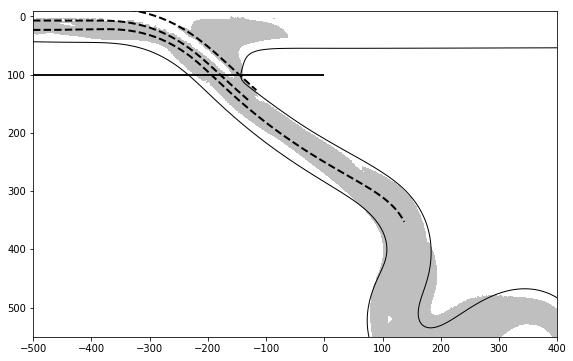

In [79]:
fig, ax = plt.subplots(figsize=(10,6)) 


ax.plot(2900.*sortedData[:,0], 2900.*(1. - sortedData[:,1]), lw = 2, ls = '--', c = 'k')

ax.plot(2900.*shiftData[:,0], 2900.*(1. - shiftData[:,1]), lw = 2, ls = '--', c = 'k')
ax.plot(2900.*sortedMids[:,0], 2900.*(1. - sortedMids[:,1]), lw = 2, ls = '--', c = 'k')

#ax.plot(upperIsoReduce[:,0], upperIsoReduce[:,1],ls = '--', c = 'r')
#ax.plot(lowerIsoReduce[:,0], lowerIsoReduce[:,1],ls = '--', c = 'b')

tempContour = ax.tricontour((2900*meshData[:,0]), 2900*(1. - meshData[:,1]),  

                    temp0,
                    levels = [1150], colors= 'k', linewidths = 1 )



stressContour = ax.tricontourf((2900*meshData[:,0]), 2900*(1. - meshData[:,1]),  

                    stress,
                    levels = [30, 1e3], colors= 'grey', linewidths = 1, alpha = 0.5 )




ax.hlines(100, -500, 0)
ax.hlines(100, -500, 0)

ax.set_xlim(-500, 400)
ax.set_ylim(550, -10)
ax.set_aspect('equal')

In [80]:
# mask isotherms and connect with midpoints

p = tempContour.collections[0].get_paths()
pv = [path.vertices for path in p]
Iso1 = np.concatenate(pv)                    #already dimensionalized

refDepth = 100.

mdd = 100.   ###############Need to switch this


mask = np.logical_and(np.logical_and(Iso1[:,1] < 400, Iso1[:,1] > refDepth), Iso1[:,0] > (trench - 200.)) 
Iso1= Iso1[mask]

In [81]:
sortedMids = prune_recursive(sortedMids, 5, tol = 0.7,safe=20)

fy = CubicSpline(2900.*sortedMids[:,0], (1 - sortedMids[:,1])*2900. )
y1Mid = fy.derivative(1)(sortedMids[:,0])
normals_rad = np.arctan(y1Mid) + np.pi/2


#Partition the the isotherm
mask = Iso1[:,1] < fy(Iso1[:,0])
upperIso = Iso1[mask,:]
lowerIso = Iso1[np.invert(mask),:]

tol = 20
mask2 = upperIso[:,1] > (mdd + tol)
upperIso = upperIso[mask2,:]

#divide data above below the MDD
mask = (1.- shiftData[:,1])*2900. >= (mdd + tol) 
    
upperIntDim  = np.column_stack((shiftData[np.invert(mask),0]*2900, 
                                (1.- shiftData[np.invert(mask),1])*2900.))


upperIso = np.row_stack((upperIso, upperIntDim ))
upperIso = upperIso[upperIso[:,1] > 1]

indexes =  np.argsort(upperIso[:,0])
upperIso = upperIso[indexes]

#need to do something here so the upper isotherm is somewhat less deep, 
#so a nearly perpendicular relationship can be maintained
upperIso = upperIso[upperIso[:,1] < 500.]

reduce_ = 3
upperIsoReduce = upperIso[::reduce_, :]

#Lower half of the isotherm
ourTree = kdTree(lowerIso)
d, p  = ourTree.query(upperIsoReduce , 1)
    
lowerIsoReduce = lowerIso[p]

In [82]:
# Evaluate the pressures

In [83]:
lowerNonDim =np.column_stack((lowerIsoReduce[:,0]/2900.,
                                   (2900. - lowerIsoReduce[:,1])/2900.))
    
lowerPres = pField.evaluate(lowerNonDim)


fy = CubicSpline(upperIsoReduce[:,0], upperIsoReduce[:,1] )
y1_ = fy.derivative(1)(upperIsoReduce[:,0])
normals_rad = np.arctan(y1_) + np.pi/2


#this allows us to looks at the pressure along multiple offsets,
#but we loose some points, 
pressures = []
maskpressures = []
points = []
points2 = []
inc = 1.

upperNonDimRef = np.column_stack((upperIsoReduce[:,0]/2900.,
                                   (2900. - upperIsoReduce[:,1])/2900.))

for i in range(-2, 18, 2):
    upperNonDim =np.column_stack(( (upperIsoReduce[:,0] - i*np.cos(normals_rad)*inc)/2900.,
                                       (2900. - (upperIsoReduce[:,1] - i*np.sin(normals_rad)*inc) )/2900.))
    
    mask = upperNonDim[:,1] < 1.
    
    upperPres = pField.evaluate(upperNonDim[mask, :])
    pressures.append(upperPres)
    maskpressures.append(mask)
    #points.append( np.mean( np.array([ upperNonDimRef[mask,:], lowerNonDim[mask,:]]), axis=0 ) )
    points.append(upperNonDimRef[mask,:])
    points2.append(upperNonDim[mask,:])

In [84]:
#range(-2, 18, 2)

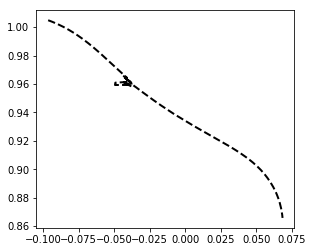

In [93]:
fig, ax = plt.subplots()

#ax.plot(lowerNonDim[:,0],lowerNonDim[:,1], lw = 2, ls = '--', c = 'k')

#for i in range(len(points)):
#    ax.scatter(points2[i][:,0],points2[i][:,1], 
#             c = pressures[i][:,0], vmin = -50, vmax =  50, s = 0.2)
    
    
ax.plot(upperNonDim[:,0],upperNonDim[:,1], lw = 2, ls = '--', c = 'k')


ax.set_aspect('equal')
#ax.set_ylim(600, 0)

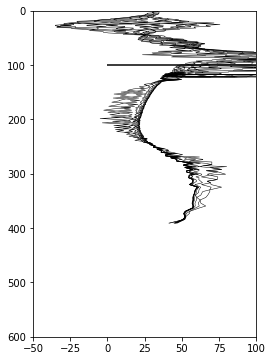

In [86]:
fig, ax = plt.subplots(figsize=(4, 6))

cp = sns.color_palette("coolwarm", len(range(0, len(pressures), 1)))

ci = 0
for i in range(len(pressures)):
    ax.plot(lowerPres[maskpressures[i],0] - pressures[i][:,0] ,
            (1. - points[i][:,1])*2900., c = 'k', lw = 0.5)
    ci+= 1
    
#ax.plot(lowerPres[maskpressures[0],0] - pressures[0][:,0],  upperIsoReduce[maskpressures[0],1] , c = 'r')

#ax.plot(savePres , savePoints , c = 'k')

ax.set_ylim(600, 0)
ax.set_xlim(-50, 100)

ax.hlines(100, 0, 150, lw = 1.5, colors = 'k')
#ax.hlines(85, 0, 150, lw = 1.5, colors = 'r')


## Grab the normal component of the weight

In [87]:

pys = np.linspace(1. - 200./2900, 0.999999, 100 )
pointsGetTemp = np.column_stack( (np.ones(len(pys))*(trenchMod - (50./2900  )), pys))

tempAcrossPlate = tField.evaluate(pointsGetTemp)[:,0]

deltaTemp = 1400. - tempAcrossPlate

dy = np.diff(pys)[0]*2900e3

#spacingMeters = np.linalg.norm(np.diff(sortedMids, axis = 0),axis = 1).mean()*2900e3
alpha = 3e-5
pressureWeight = integrate.simps(deltaTemp*3300.*9.8*alpha , x=None, dx=dy, axis=0)

slabCos = np.cos(np.arctan(gaussian_filter(y1_, 2)))

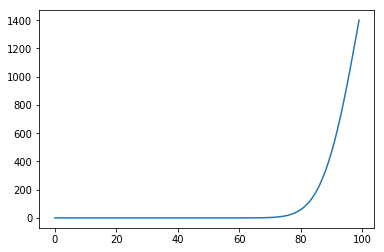

In [88]:
plt.plot(deltaTemp)

In [89]:
pressureWeight/(80e3*9.8) #the density differnce

25.863443013954068

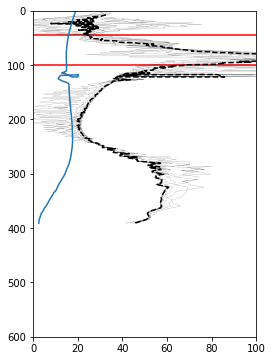

In [90]:
fig, ax = plt.subplots(figsize=(4, 6))

cp = sns.color_palette("coolwarm", len(range(0, len(pressures), 1)))

ci = 0
for i in range(len(pressures)):
    ax.plot(lowerPres[maskpressures[i],0] - pressures[i][:,0] ,
            (1. - points[i][:,1])*2900., c = 'k', lw = 0.1)
    ci+= 1

indexToPlot = 5
ax.plot(lowerPres[maskpressures[indexToPlot],0] - pressures[indexToPlot][:,0],  
        upperIsoReduce[maskpressures[indexToPlot],1] , c = 'k', ls = '--')



#mask = np.logical_and((1. - points2[indexToPlot][:,1][1:])*2900. > mdd, 
#                     pressureWeight*1e-6*slabCos[maskpressures[indexToPlot]][:-1] < 
#                     (lowerPres[maskpressures[indexToPlot],0] - pressures[indexToPlot][:,0])[:-1])

#ax.fill_betweenx((1. - points2[indexToPlot][:,1][1:][mask])*2900., 
#                pressureWeight*1e-6*slabCos[maskpressures[indexToPlot]][:-1][mask], 
#                ((lowerPres[maskpressures[indexToPlot],0] - pressures[indexToPlot][:,0])[:-1])[mask],
#                color = 'r')                 
                 

ax.plot(slabCos*pressureWeight*1e-6, upperIsoReduce[:,1])

ax.set_ylim(600, 0)
ax.set_xlim(0, 100)


ax.hlines(100, 0, 150, lw = 1.5, colors = 'r')
ax.hlines(45, 0, 150, lw = 1.5, colors = 'r')


In [65]:
#(80*100e3*10)*1e-6

In [66]:
#lowerPresSave = lowerPres
#pressuresSave = pressures
#pointsSave = points
#maskpressuresSave = maskpressures
#slabNormalSave = slabCos*pressureWeight*1e-6

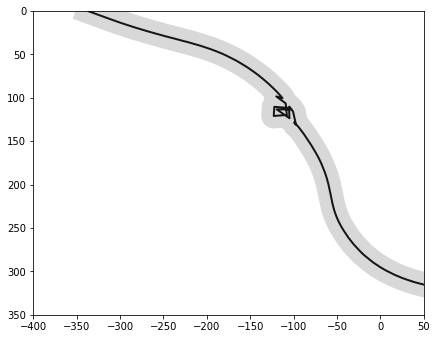

In [67]:
import matplotlib.patheffects as pe

fig, ax = plt.subplots(figsize=(7, 7))




#ax.plot(2900.*(points2[indexToPlot][::10,0]), 
#           gaussian_filter((1.0 - points2[indexToPlot][::10,1])*2900., 0), lw = 25, ls = '--', c = 'k', alpha = 0.1 )


ax.plot(2900.*(points2[indexToPlot][::1,0]), 
           gaussian_filter((1.0 - points2[indexToPlot][::1,1])*2900., 0), lw = 2, ls = '-', c = 'k', alpha = 0.9, 
       path_effects=[pe.Stroke(linestyle='-',linewidth=25, foreground='gray', alpha= 0.3), pe.Normal()])



#ax.plot(points2[0][:,0]*2900., (1. - points2[0][:,1])*2900.,ls = '--', c = 'r')
#ax.plot(points2[indexToPlot][:,0]*2900., (1. - points2[indexToPlot][:,1])*2900.,ls = '--', c = 'r')
#ax.plot(points2[-1][:,0]*2900., (1. - points2[-1][:,1])*2900.,ls = '--', c = 'r')

#ax.plot(upperIsoReduce[:,0], upperIsoReduce[:,1],ls = '--', c = 'r')
#ax.plot(lowerIsoReduce[:,0], lowerIsoReduce[:,1],ls = '--', c = 'b')




#ax.set_xlim(-300, 0)
ax.set_xlim(-400., 50)
#ax.set_xlim(-250., 100)

ax.set_ylim(350, 0)
ax.set_aspect('equal')

In [68]:
#fig, ax = plt.subplots()

#cb = ax.tricontourf((2900*mesh.subMesh.data[:,0]), 2900*(1. - mesh.subMesh.data[:,1]),  

#                    press,
#                    #levels = [-240., -180., -120.,  -60.,    0.,   60.,  120.,  180.,  240.],
#                    #vmin = -240,vmax = 240, 
#                    cmap='RdBu_r', alpha=0.8)#, 

In [69]:
mesh.subMesh.data.shape, press.shape

((221184, 2), (221184,))

In [70]:
import matplotlib.patches as patches

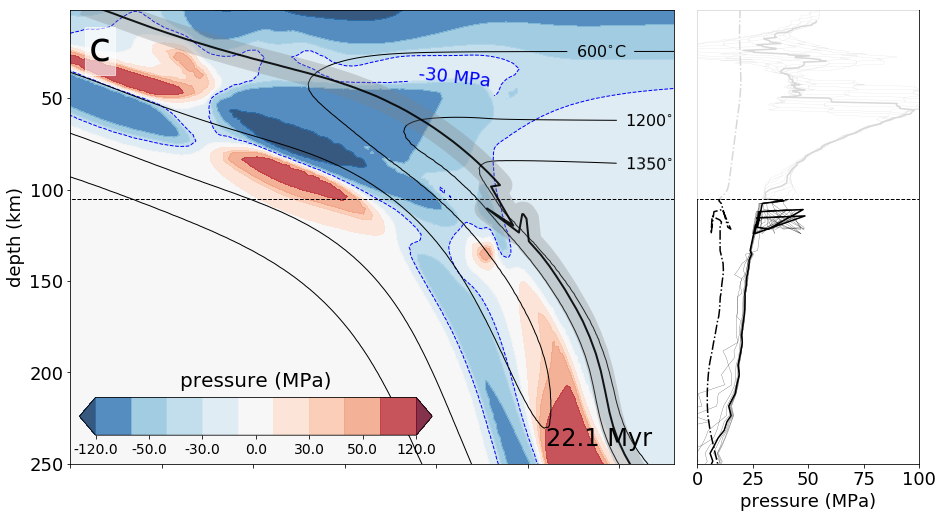

In [71]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex='col', sharey=True,
                               gridspec_kw={'width_ratios': [4, 1.]},
                               figsize=(14, 7))

fig.set_tight_layout({'rect': [0, 0, 1, 1], 'pad': 0.0, 'h_pad': 0.1})

ax = axes[0]

cb = ax.tricontourf((2900*mesh.subMesh.data[:,0]), 2900*(1. - mesh.subMesh.data[:,1]),  
                    press - press.mean(),
                    #levels =  [-150., -100.,  -50., -10, 10,  50., 100, 150],
                    #vmin = -150,vmax = 150, 
                    levels = [-120.,  -60.,  -40, -30, -10,  10., 30, 40,   60.,  120.],
                    #vmin = -240,vmax = 240, 
                    cmap='RdBu_r', alpha=0.8, extend= 'both')#, 

    
pressContour = ax.tricontour((2900*mesh.subMesh.data[:,0]), 2900*(1. - mesh.subMesh.data[:,1]),  
                    press - press.mean(),
                    levels = [  -30], 
                    colors= 'b', linewidths = 1 )
    
tempContour = ax.tricontour((2900*meshData[:,0]), 2900*(1. - meshData[:,1]),  

                    temp,
                    levels = [600, 1200, 1350], colors= 'k', linewidths = 1 )



#stressContour = ax.tricontour((2900*meshData[:,0]), 2900*(1. - meshData[:,1]),  
#                    stress,
#                    levels = [40, 1e3], colors= 'r', linestyles = '--', linewidths = 1.5, alpha = 0.7 )


#stressContour2 = ax.tricontourf((2900*meshData[:,0]), 2900*(1. - meshData[:,1]),  
#
#                    stress,
#                    levels = [40, 1e3], colors= 'r', linestyles = '--', linewidths = 1.5, alpha = 0.2 )


#velContour = ax.tricontour((2900*meshData[:,0]), 2900*(1. - meshData[:,1]),  
#                    velMag,
#                    levels = [ 0.5], 
#                    colors= 'g', linewidths = 1.5, linestyles='--' )

ax.hlines(refDepth + 5, -500, 500, linestyles='--', lw = 1, label = 'MDD')


#ax.plot(2900.*(points2[indexToPlot][::1,0]), 
#           gaussian_filter((1.0 - points2[indexToPlot][::1,1])*2900., 0), lw = 25, c = 'k', alpha = 0.3,
#       label = '')

#ax.plot(2900.*(points2[indexToPlot][::3,0]), 
#           gaussian_filter((1.0 - points2[indexToPlot][::3,1])*2900., 3) + 600., lw = 15, c = 'k', alpha = 0.3,
#       label = 'pressure measure region')

ax.plot(2900.*(points2[indexToPlot][::2,0]), 
           gaussian_filter((1.0 - points2[indexToPlot][::2,1])*2900., 0), lw = 2, ls = '-', c = 'k', alpha = 0.9, 
        label = 'pressure measure region', 
       path_effects=[pe.Stroke(linestyle='-',linewidth=25, foreground='gray', alpha= 0.3), pe.Normal()])

#for stream in listOfLines:
#    ax.plot(2900.*stream[:,0], 2900.*(1. - stream[:,1]), ls = '--', lw = 1, c = 'g')



#ax.plot(points2[0][:,0]*2900., (1. - points2[0][:,1])*2900., 
#ls = '--', c = 'r', lw = 4, label = 'slab top', zorder=1000)

#ax.plot(points2[indexToPlot][:,0]*2900., (1. - points2[indexToPlot][:,1])*2900.,ls = '--', c = 'k')


#ax.set_xlim(-400, -80)
ax.set_xlim(-350, -270 + 250)  #deep

#ax.set_ylim(200, 0)
ax.set_aspect('equal')


ax2 = axes[1]


for i in range(len(pressures)):
    ax2.plot(lowerPres[maskpressures[i],0] - pressures[i][:,0] ,
            (1. - points[i][:,1])*2900., c = 'k', lw = 0.2)

ax2.plot(lowerPres[maskpressures[indexToPlot],0] - pressures[indexToPlot][:,0],  
        upperIsoReduce[maskpressures[indexToPlot],1] , c = 'k', ls = '-', label = 'slab \npressure \ndifference')

ax2.plot(slabCos*pressureWeight*1e-6, upperIsoReduce[:,1], c = 'k', ls = '-.', label = 'slab \nweight')

ax2.hlines(refDepth  + 5, -250, 200, colors='k', linestyles='--', lw = 1)
#ax2.vlines(30, 0, 250, colors='k', linestyles='--', lw = 1)


ax2.set_xlim(0, 100)
ax2.set_ylim(250, 2)

ax.set_ylabel('depth (km)', fontsize= 18)
ax.yaxis.set_tick_params(labelsize=18)
ax2.set_xlabel('pressure (MPa)', fontsize= 18)
ax2.xaxis.set_tick_params(labelsize=18)

#t = ax.text(  -100 + 0, 30, 'a', fontsize = 40) #shallow
#t = ax.text(  -100 + 130, 30, 'b', fontsize = 40) #deep

t = ax.text(  -340, 30, 'c', fontsize = 40) #deep

t.set_bbox(dict(facecolor='white', alpha=0.6, edgecolor='white'))

cl = ax.clabel(pressContour, fontsize=18, inline=1, fmt='%1.0f' + ' MPa', #shalow
           manual=[(-140 , 45)], inline_spacing=6)


#cl3 = ax.clabel(stressContour, fontsize=16, inline=1, fmt='%1.0f' + ' MPa', #shalow
#           manual=[(-180 , 150)], inline_spacing=6)

#cl2 = ax.clabel(tempContour, fontsize=16, inline=1, fmt='%1.0f' + r'$^{\circ}$C', #shallow
#           manual=[(-100 + 0, 50), (-100 + 0, 80)], inline_spacing=6)


cl2 = ax.clabel(tempContour, fontsize=16, inline=1, fmt='%1.0f' + r'$^{\circ}$C',  #deep
           manual=[(-60, 20), (-30, 60), (-30, 80)], inline_spacing=6)


#ax.fill_between(dimIntData[indexWedge:,0], 
#                 dimIntData[indexWedge:,1], 45*np.ones(len(dimIntData[indexWedge:,1])), 
#                 facecolor='g', alpha=0.3) 





ax.get_xaxis().set_ticklabels([])

ax2.yaxis.set_ticks_position('none') 

# Create a Rectangle patch
rect = patches.Rectangle((0,0),100, refDepth +5 ,linewidth=1,edgecolor='none',facecolor='white', zorder = 1e3, alpha=0.85)

# Add the patch to the Axes
ax2.add_patch(rect)

ax.text(-90, 240, 
        '{0:0.1f} Myr'.format((testDf.timeAtSave.iloc[index]*timeScale)), fontsize=24)




#ax.text(-322, 11, 
#        'subduction interface', fontsize=16, rotation=-26)

#ax.text(-230, 45, 
#        'subduction interface', fontsize=16, rotation=-40)


#Dummy legend entitities
ax.plot([-1000, -1001,], [-1000, -1001], ls = '--', c = 'r',lw=1, label = r'$\sigma_{\mathrm{II}}$ isovalue')
ax.plot([-1000, -1001,], [-1000, -1001], ls = '--', c = 'b', lw=1, label = 'dynamic pressure isovalue')


#ax.legend(loc = 4, fontsize= 18)
#ax2.legend(loc = 4, fontsize= 14)

#ax.text(-162, 57, 
#        'LVW', fontsize=18, rotation=0, color= 'g')


cbticks = [-120.,  -50.,-30.,  0., 30., 50., 120.]
cbaxes = fig.add_axes([0.15, 0.15, 0.35, 0.075]) 
cb1 = colorbar(cb, cax = cbaxes, orientation="horizontal")
cb1.set_ticks(cbticks,  update_ticks=True)
cb1.set_ticklabels(cbticks)
cb1.set_label('pressure (MPa)', size= 20, labelpad=-85)
cbaxes.tick_params(labelsize=14)

fig.tight_layout()

#cl3 = ax.clabel(velContour, fontsize=16, inline=1, fmt='%1.1f' + r' cm/y', 
#           manual=[(270, 60)], inline_spacing=6)


In [234]:
#fig.savefig('pressure3.png', dpi=200, bbox_inches='tight')

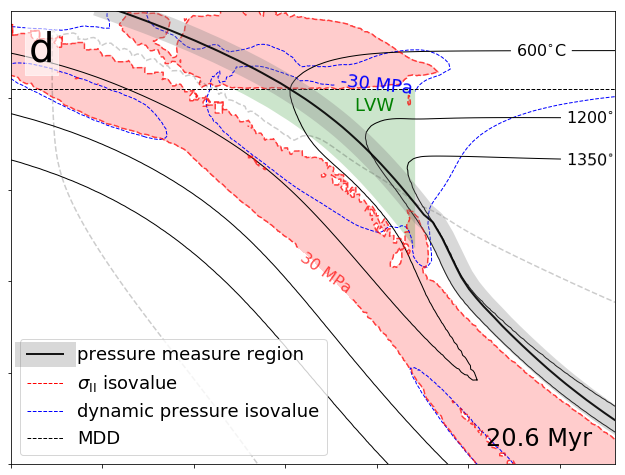

In [292]:
fig, ax = plt.subplots(figsize=(11.2, 6.4))

fig.set_tight_layout({'rect': [0, 0, 1, 1], 'pad': 0.0, 'h_pad': 0.1})



#cb = ax.tricontourf((2900*mesh.subMesh.data[:,0]), 2900*(1. - mesh.subMesh.data[:,1]),  
#                    press - press.mean(),
#                    #levels =  [-150., -100.,  -50., -10, 10,  50., 100, 150],
#                    #vmin = -150,vmax = 150, 
#                    cmap='RdBu_r', alpha=0.8, extend= 'both')#, 

    
pressContour = ax.tricontour((2900*mesh.subMesh.data[:,0]), 2900*(1. - mesh.subMesh.data[:,1]),  
                    press - press.mean(),
                    levels = [  -30], 
                    colors= 'b', linewidths = 1 )
    
tempContour = ax.tricontour((2900*meshData[:,0]), 2900*(1. - meshData[:,1]),  

                    temp,
                    levels = [600, 1200, 1350], colors= 'k', linewidths = 1 )



stressContour = ax.tricontour((2900*meshData[:,0]), 2900*(1. - meshData[:,1]),  

                    stress,
                    levels = [30, 1e3], colors= 'r', linestyles = '--', linewidths = 1.5, alpha = 0.7 )


stressContour2 = ax.tricontourf((2900*meshData[:,0]), 2900*(1. - meshData[:,1]),  

                    stress,
                    levels = [30, 1e3], colors= 'r', linestyles = '--', linewidths = 1.5, alpha = 0.2 )


velContour = ax.tricontour((2900*meshData[:,0]), 2900*(1. - meshData[:,1]),  

                    vel[:,1]*velScale,
                    levels = [ -2.], colors= 'k', linestyles = '--', linewidths = 1.5, alpha = 0.2 )




#velContour = ax.tricontour((2900*meshData[:,0]), 2900*(1. - meshData[:,1]),  
#                    velMag,
#                    levels = [ 0.5], 
#                    colors= 'g', linewidths = 1.5, linestyles='--' )

ax.hlines(refDepth + 5, -500, 500, linestyles='--', lw = 1, label = 'MDD')


#ax.plot(2900.*(points2[indexToPlot][::1,0]), 
#           gaussian_filter((1.0 - points2[indexToPlot][::1,1])*2900., 0), lw = 25, c = 'k', alpha = 0.3,
#       label = '')

#ax.plot(2900.*(points2[indexToPlot][::3,0]), 
#           gaussian_filter((1.0 - points2[indexToPlot][::3,1])*2900., 3) + 600., lw = 15, c = 'k', alpha = 0.3,
#       label = 'pressure measure region')

ax.plot(2900.*(points2[indexToPlot][::2,0]), 
           gaussian_filter((1.0 - points2[indexToPlot][::2,1])*2900., 0), lw = 2, ls = '-', c = 'k', alpha = 0.9, 
        label = 'pressure measure region', 
       path_effects=[pe.Stroke(linestyle='-',linewidth=25, foreground='gray', alpha= 0.3), pe.Normal()])

#for stream in listOfLines:
#    ax.plot(2900.*stream[:,0], 2900.*(1. - stream[:,1]), ls = '--', lw = 1, c = 'g')



#ax.plot(points2[0][:,0]*2900., (1. - points2[0][:,1])*2900., 
#ls = '--', c = 'r', lw = 4, label = 'slab top', zorder=1000)

#ax.plot(points2[indexToPlot][:,0]*2900., (1. - points2[indexToPlot][:,1])*2900.,ls = '--', c = 'k')


#ax.set_xlim(-400, -80)
ax.set_xlim(-350, -270 + 250)  #deep

ax.set_ylim(250, 2)

#ax.set_ylim(200, 0)
ax.set_aspect('equal')




#t = ax.text(  -100 + 0, 30, 'a', fontsize = 40) #shallow
t = ax.text(  -340, 30, 'd', fontsize = 40) #deep

t.set_bbox(dict(facecolor='white', alpha=0.6, edgecolor='white'))

cl = ax.clabel(pressContour, fontsize=18, inline=1, fmt='%1.0f' + ' MPa', #shalow
           manual=[(-150 , 45)], inline_spacing=6)


cl3 = ax.clabel(stressContour, fontsize=16, inline=1, fmt='%1.0f' + ' MPa', #shalow
           manual=[(-180 , 150)], inline_spacing=6)

#cl2 = ax.clabel(tempContour, fontsize=16, inline=1, fmt='%1.0f' + r'$^{\circ}$C', #shallow
#           manual=[(-100 + 0, 50), (-100 + 0, 80)], inline_spacing=6)


cl2 = ax.clabel(tempContour, fontsize=16, inline=1, fmt='%1.0f' + r'$^{\circ}$C',  #deep
           manual=[(-60, 20), (-30, 60), (-30, 80)], inline_spacing=6)


ax.fill_between(dimIntData[indexWedge:,0], 
                 dimIntData[indexWedge:,1], 45*np.ones(len(dimIntData[indexWedge:,1])), 
                 facecolor='g', alpha=0.2) 





ax.get_xaxis().set_ticklabels([])
ax.get_yaxis().set_ticklabels([])


ax2.yaxis.set_ticks_position('none') 

# Create a Rectangle patch
rect = patches.Rectangle((0,0),100, mdd +5 ,linewidth=1,edgecolor='none',facecolor='white', zorder = 1e3, alpha=0.85)

# Add the patch to the Axes
ax2.add_patch(rect)

ax.text(-90, 240, 
        '{0:0.1f} Myr'.format((testDf.timeAtSave.iloc[index]*timeScale)), fontsize=24)



#ax.text(-322, 11, 
#        'subduction interface', fontsize=16, rotation=-26)

#ax.text(-230, 45, 
#        'subduction interface', fontsize=16, rotation=-40)


#Dummy legend entitities
ax.plot([-1000, -1001,], [-1000, -1001], ls = '--', c = 'r',lw=1, label = r'$\sigma_{\mathrm{II}}$ isovalue')
ax.plot([-1000, -1001,], [-1000, -1001], ls = '--', c = 'b', lw=1, label = 'dynamic pressure isovalue')


ax.legend(loc = 3, fontsize= 18)
#ax2.legend(loc = 4, fontsize= 14)

ax.text(-162, 57, 
        'LVW', fontsize=18, rotation=0, color= 'g')

fig.tight_layout()

#cl3 = ax.clabel(velContour, fontsize=16, inline=1, fmt='%1.1f' + r' cm/y', 
#           manual=[(270, 60)], inline_spacing=6)


In [262]:
#(velScale*vel[:,1]).min()

-8.3956212029048896

In [240]:
#fig.savefig('pressure4.png', dpi=200, bbox_inches='tight')

In [43]:
#fig.savefig('shallow_pressure.png', dpi=200, bbox_inches='tight')
#fig.savefig('deep_pressure.png', dpi=200, bbox_inches='tight')

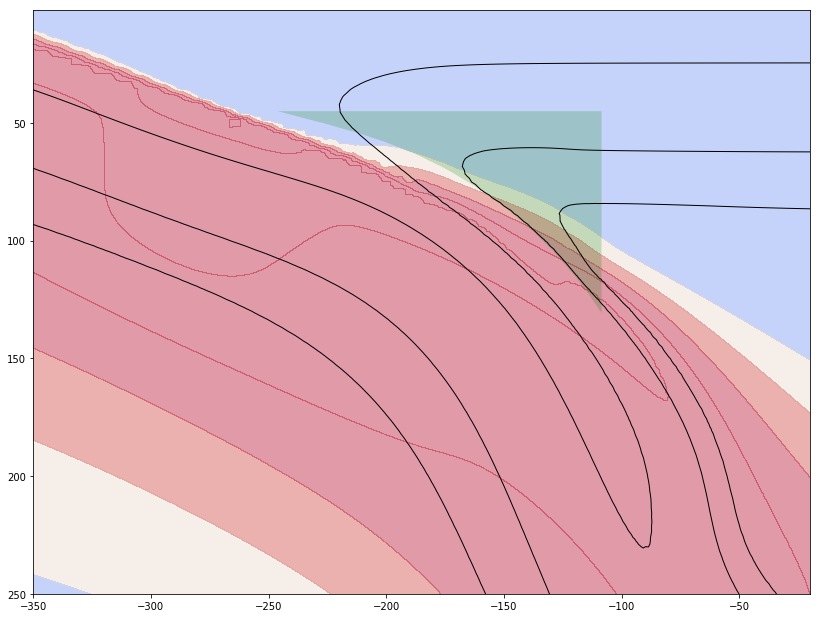

In [405]:
fig, ax = plt.subplots(figsize=(11.2, 9.4))

fig.set_tight_layout({'rect': [0, 0, 1, 1], 'pad': 0.0, 'h_pad': 0.1})



#cb = ax.tricontourf((2900*mesh.subMesh.data[:,0]), 2900*(1. - mesh.subMesh.data[:,1]),  
#                    press - press.mean(),
#                    #levels =  [-150., -100.,  -50., -10, 10,  50., 100, 150],
#                    #vmin = -150,vmax = 150, 
#                    cmap='RdBu_r', alpha=0.8, extend= 'both')#, 

    

tempContour = ax.tricontour((2900*meshData[:,0]), 2900*(1. - meshData[:,1]),  

                   temp,
                    levels = [600, 1200, 1350], colors= 'k', linewidths = 1 )


velContour = ax.tricontourf((2900*meshData[:,0]), 2900*(1. - meshData[:,1]),  
                    np.linalg.norm(velRef, axis=1)*velScale,
                    #np.abs(vel[:,1]*velScale),
                    alpha=0.4, cmap='coolwarm',
                         vmin = 0.1,  vmax = 4, extend = 'max')


ax.fill_between(dimIntData[indexWedge:,0], 
                 dimIntData[indexWedge:,1], 45*np.ones(len(dimIntData[indexWedge:,1])), 
                 facecolor='g', alpha=0.2) 

ax.set_xlim(-350, -270 + 250)  #deep

ax.set_ylim(250, 2)

#ax.set_ylim(200, 0)
ax.set_aspect('equal')

In [336]:
np.linalg.norm(vel, axis=1).max()*velScale

8.4280946561722949

In [305]:
xres

1152

In [310]:
#vel[:,0] -= vel[:,0].min()*velScale
#vel[-xres:,0].min()*velScale

-1.9986737634257041

## Old

In [ ]:
dimIntData

ax1.fill_between(dimIntData[indexWedge:,0], 
                 dimIntData[indexWedge:,1], 45*np.ones(len(dimIntData[indexWedge:,1])), 
                 facecolor='gray', alpha=0.65) 